In [40]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [11]:
# %aimport experiments
import experiments as meas

In [12]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [13]:
# expt_path=os.getcwd()+'\data_220904'
expt_path=os.getcwd()+'\data_220919'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_220919


In [14]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [15]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [16]:
im = InstrumentManager()

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 6100000000.0
set power to 10.0


In [17]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# Sweep qubits

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [25]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 824.7643895224713, HWHM 0.6865559481908957
Found peak in I at [MHz] 824.7749840217, HWHM 0.6869257443437827
Found peak in Q at [MHz] 824.7696474628651, HWHM 0.8964590824756398


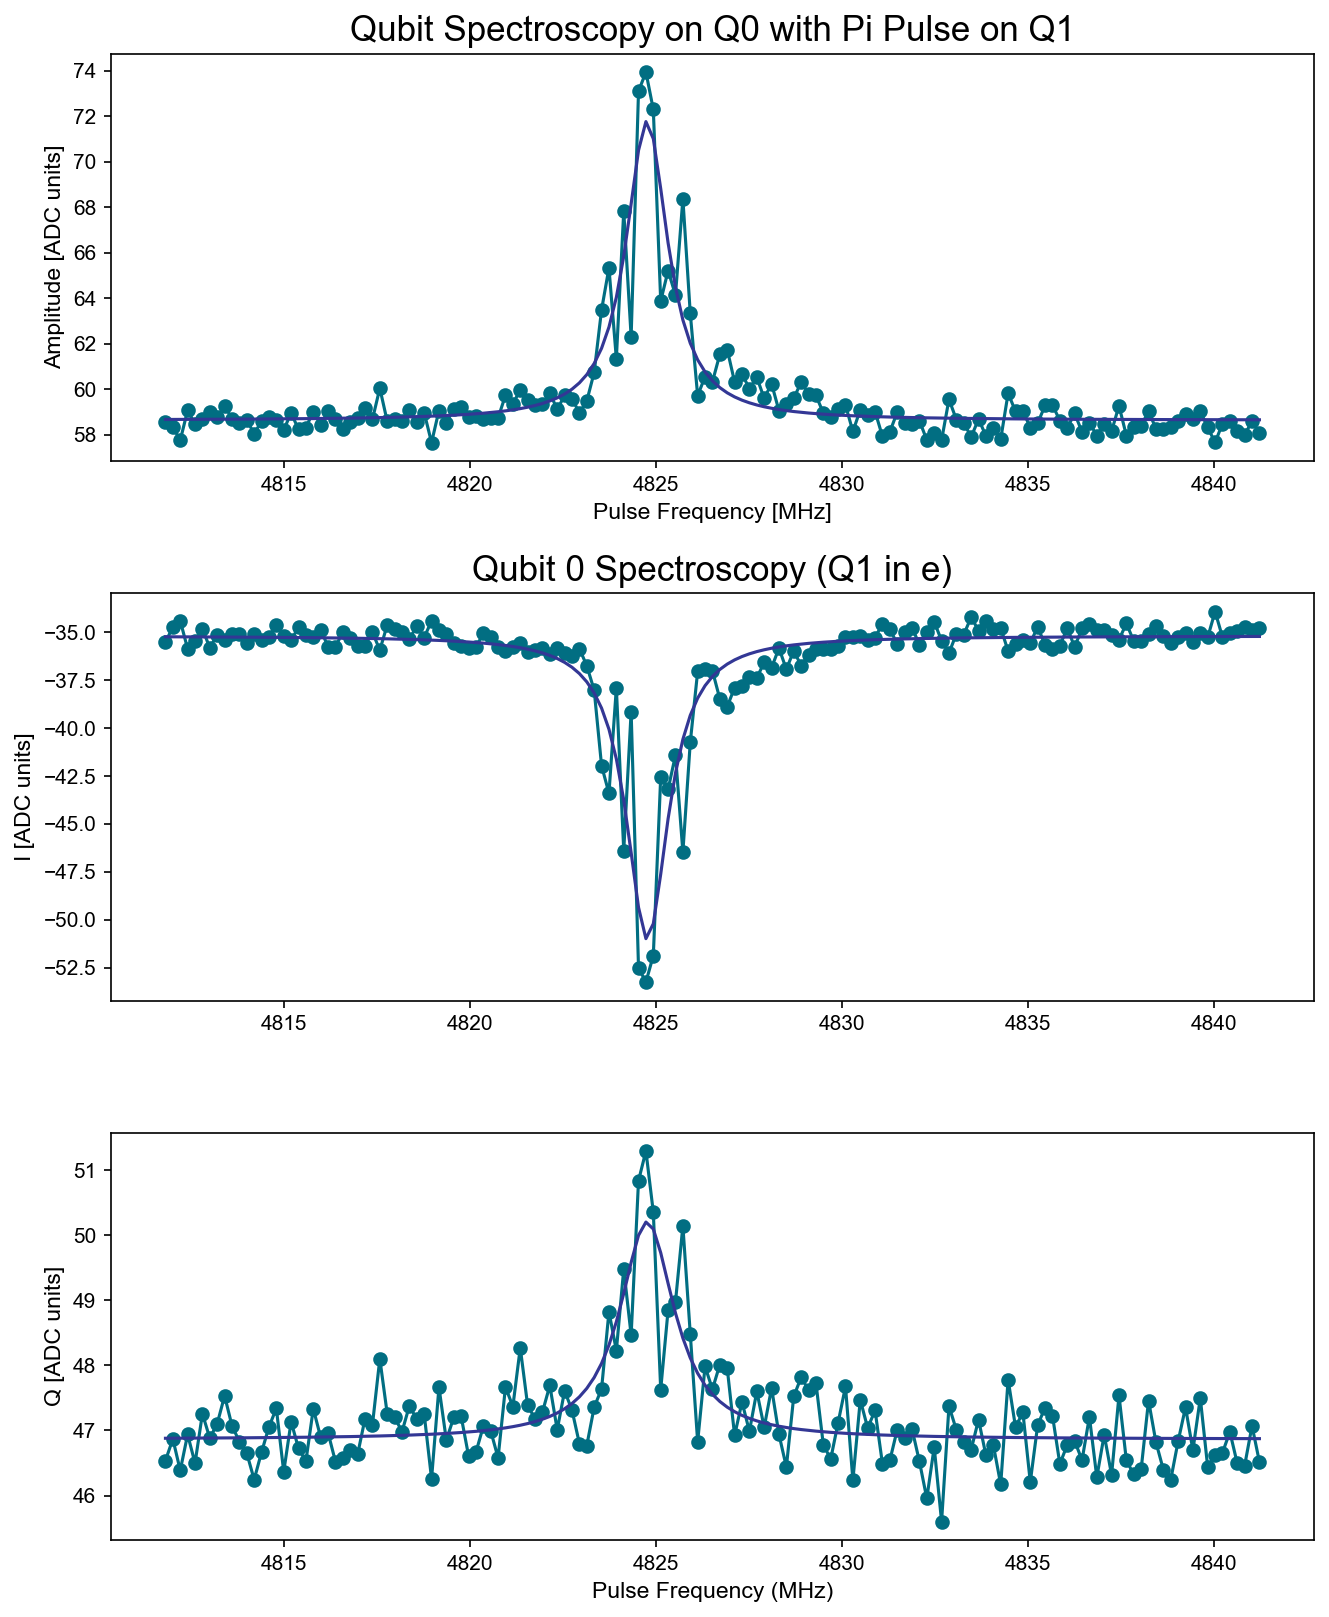

Fit Q0 frequency with ZZ shift [MHz]: 824.7643895224713
Q0 shift due to Q1 in e [MHz]: -1.8602524117811754


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 825.6270946093442, HWHM 0.6320049166587166
Found peak in I at [MHz] 825.6230273844322, HWHM 0.7099143303829958
Found peak in Q at [MHz] 825.6287048101116, HWHM -0.5429957820574013


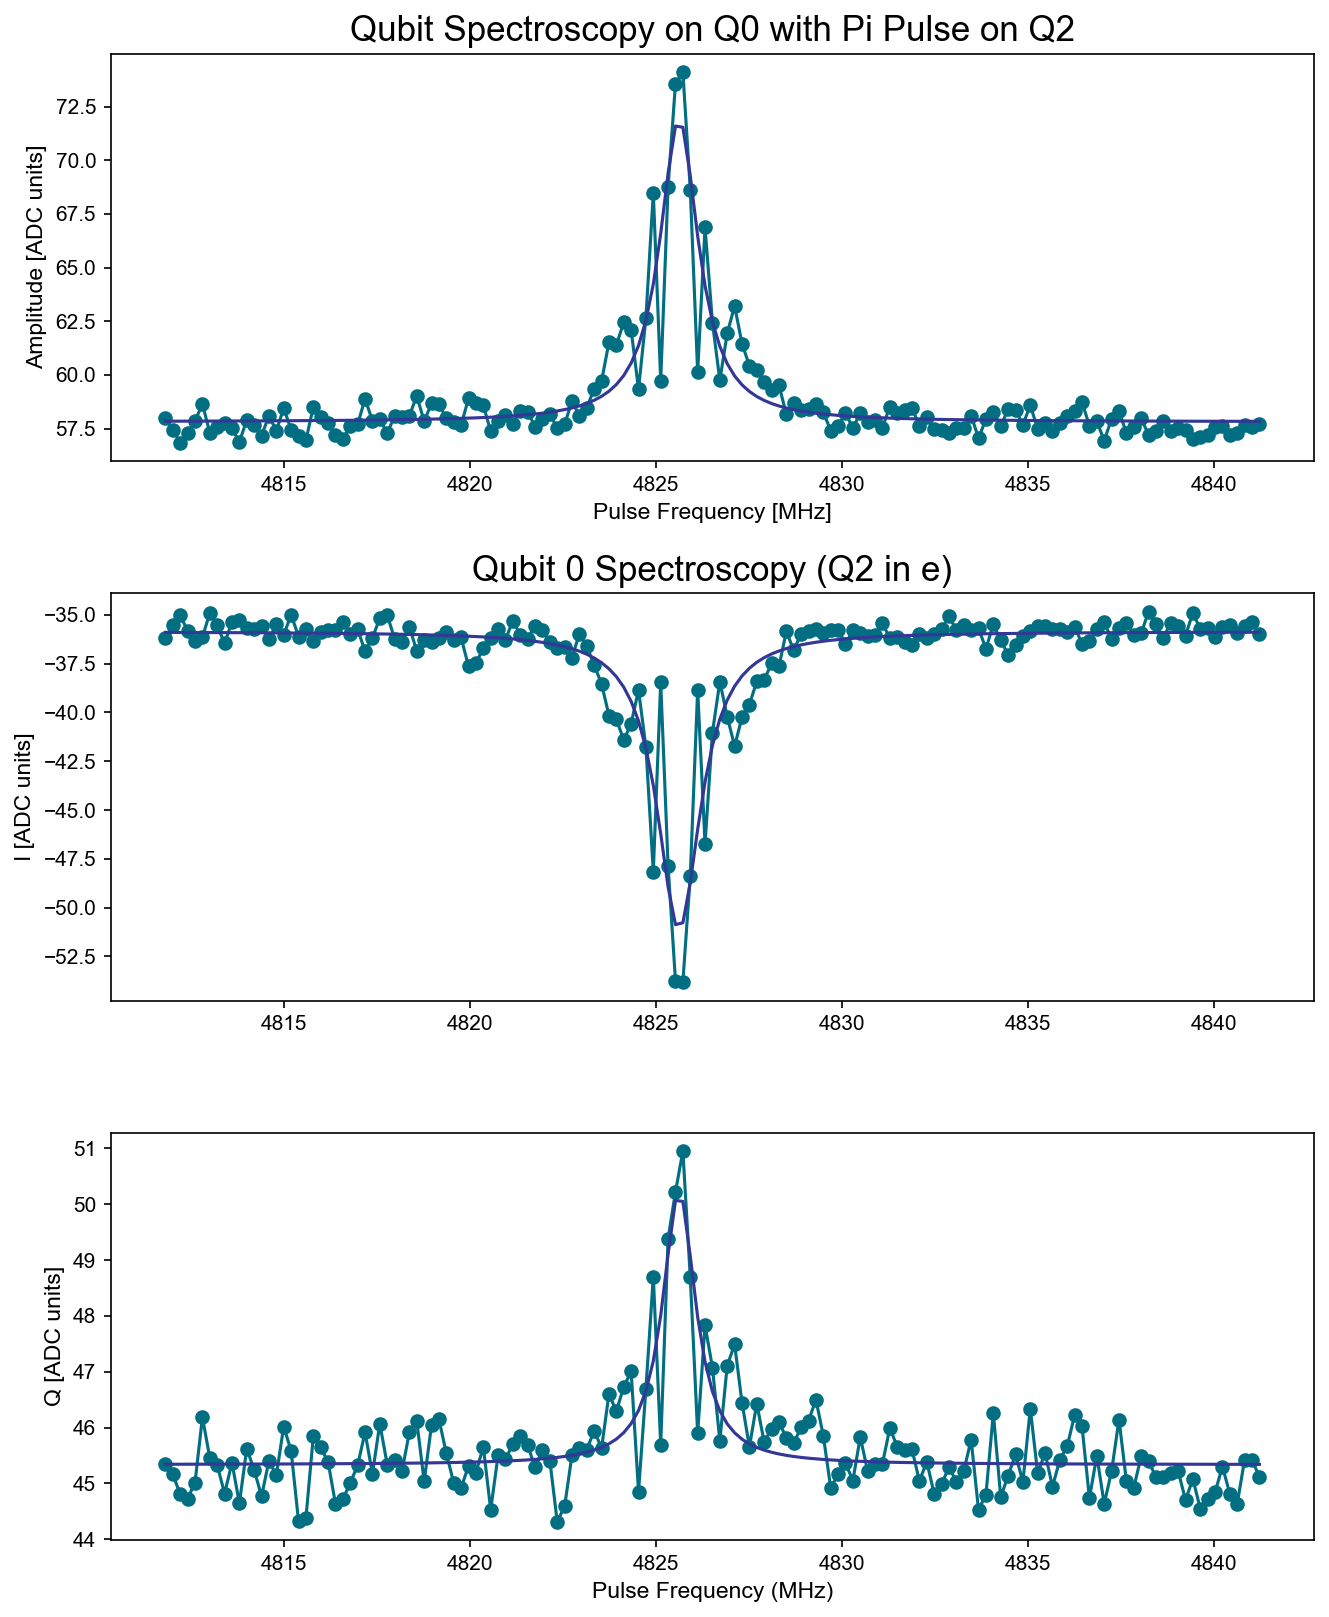

Fit Q0 frequency with ZZ shift [MHz]: 825.6270946093442
Q0 shift due to Q2 in e [MHz]: -0.9975473249082825


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 825.242795524565, HWHM 0.8056691833293523
Found peak in I at [MHz] 825.247778983761, HWHM 0.8514828449764424
Found peak in Q at [MHz] 825.2296980274092, HWHM 0.7964570792277583


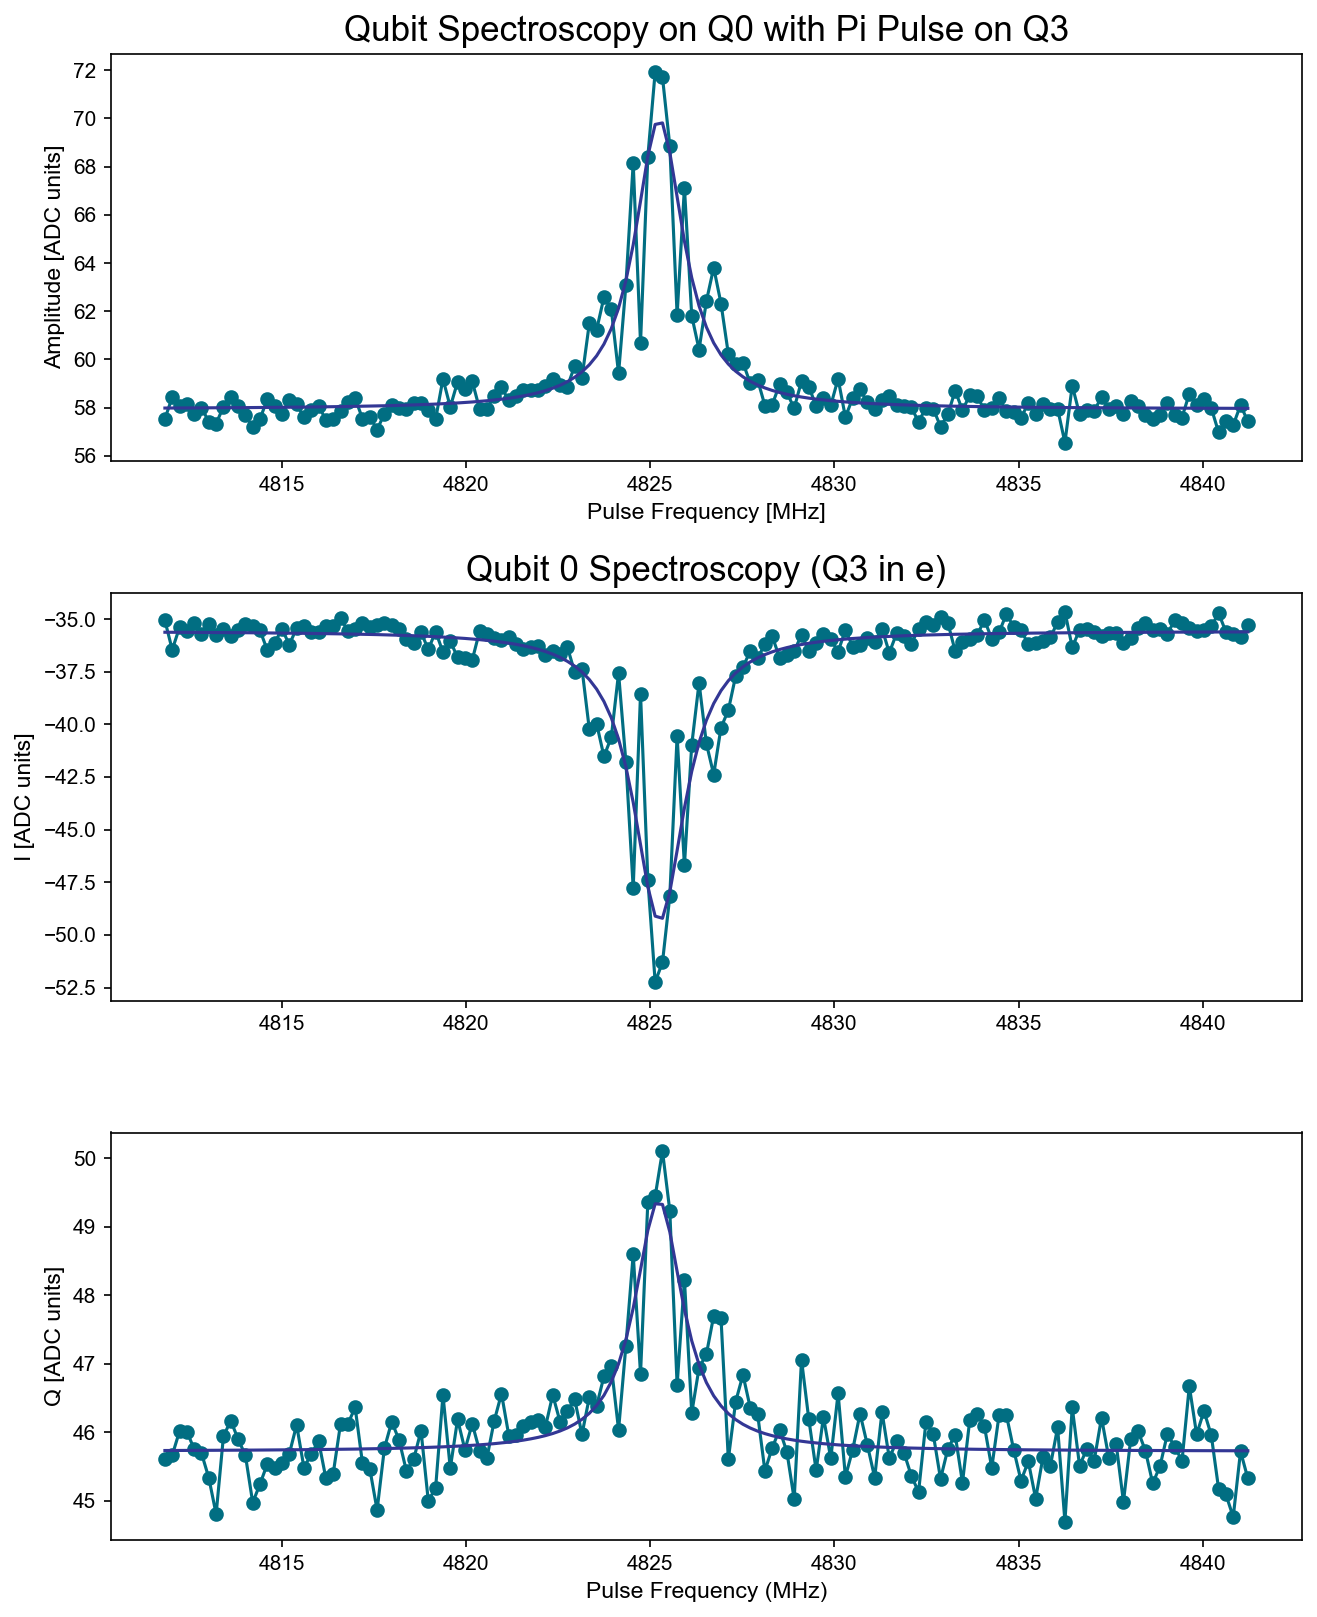

Fit Q0 frequency with ZZ shift [MHz]: 825.242795524565
Q0 shift due to Q3 in e [MHz]: -1.381846409687455


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3469.2228514652543, HWHM 1.354576762677561
Found peak in I at [MHz] 3469.22569865183, HWHM 1.3623327653495112
Found peak in Q at [MHz] 3469.117741975562, HWHM 0.9961826980402502


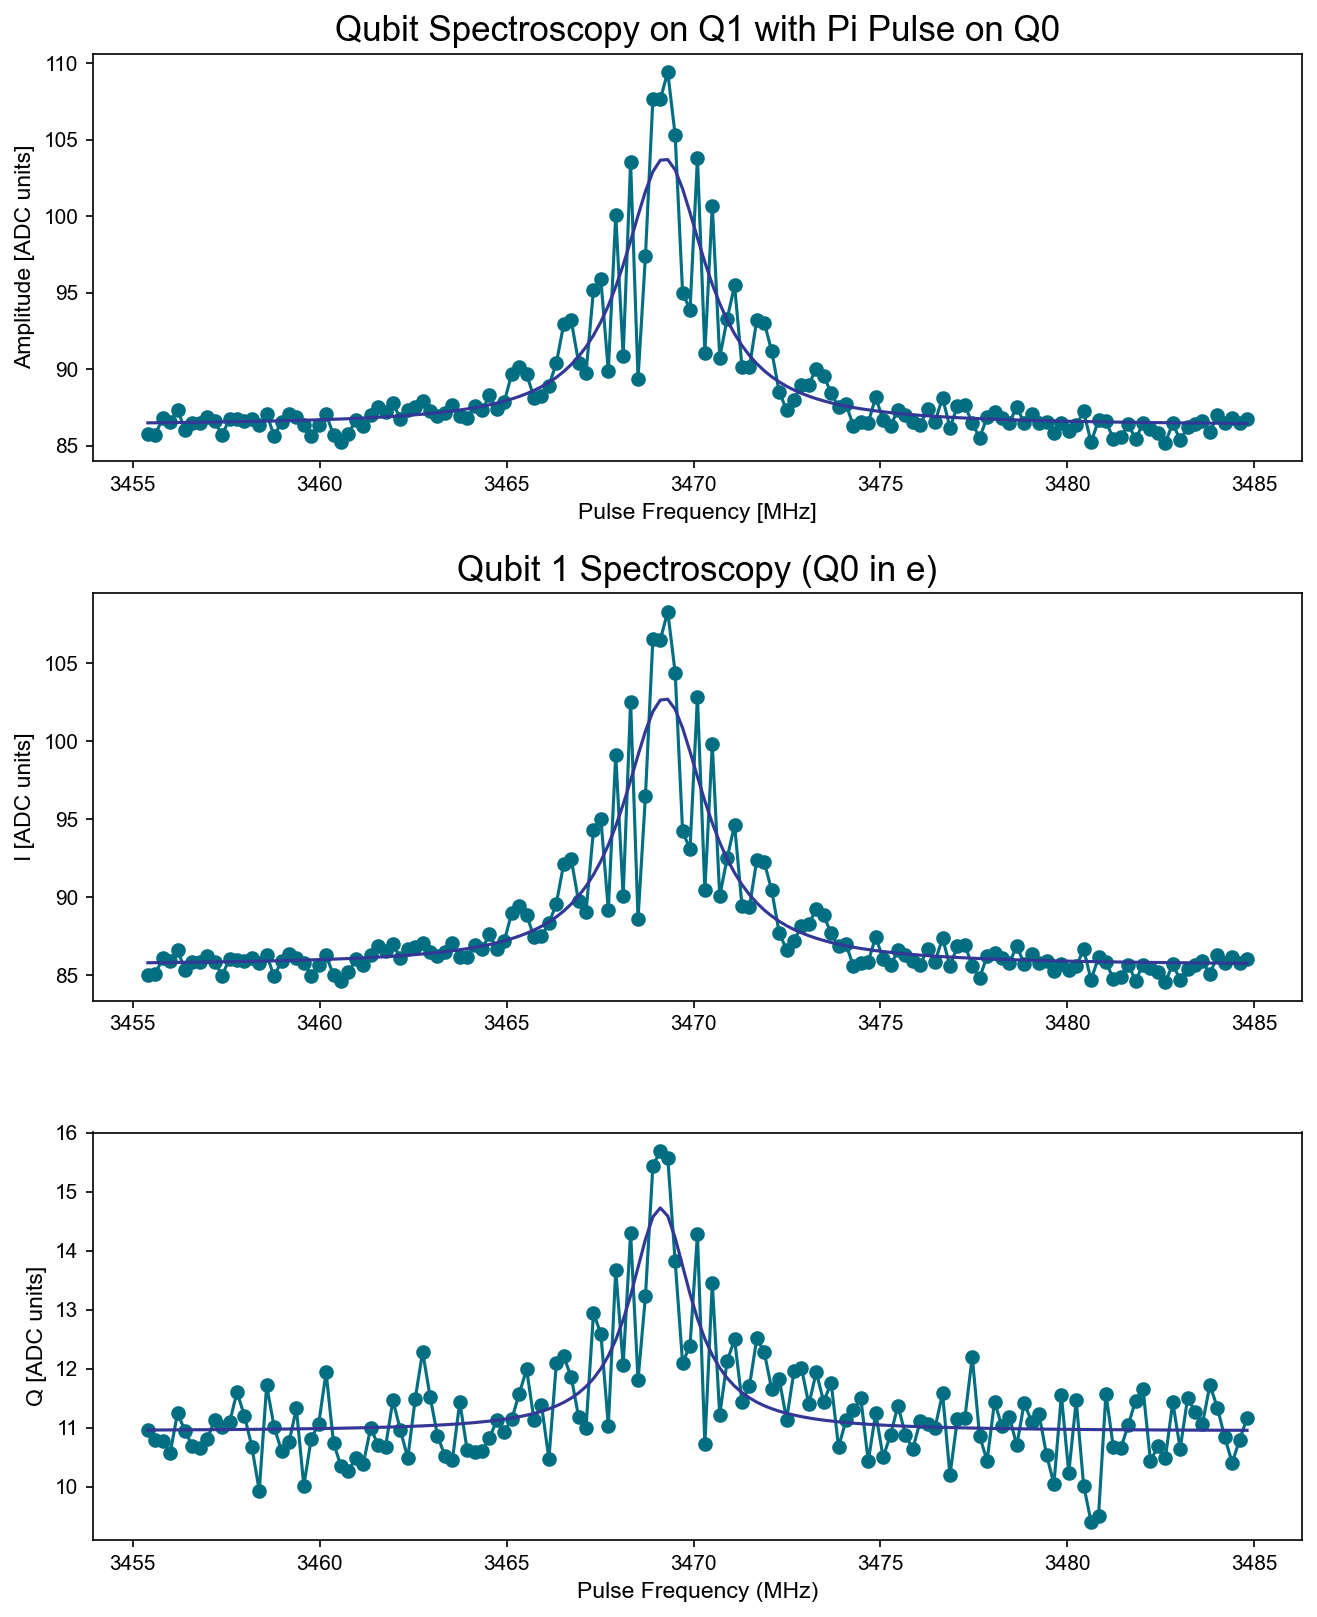

Fit Q1 frequency with ZZ shift [MHz]: 3469.117741975562
Q1 shift due to Q0 in e [MHz]: -1.0870222137232304


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3465.2477757193224, HWHM 1.847024865712221
Found peak in I at [MHz] 3465.252704343758, HWHM 1.858965541323547
Found peak in Q at [MHz] 3465.141835430923, HWHM 1.4881860028651495


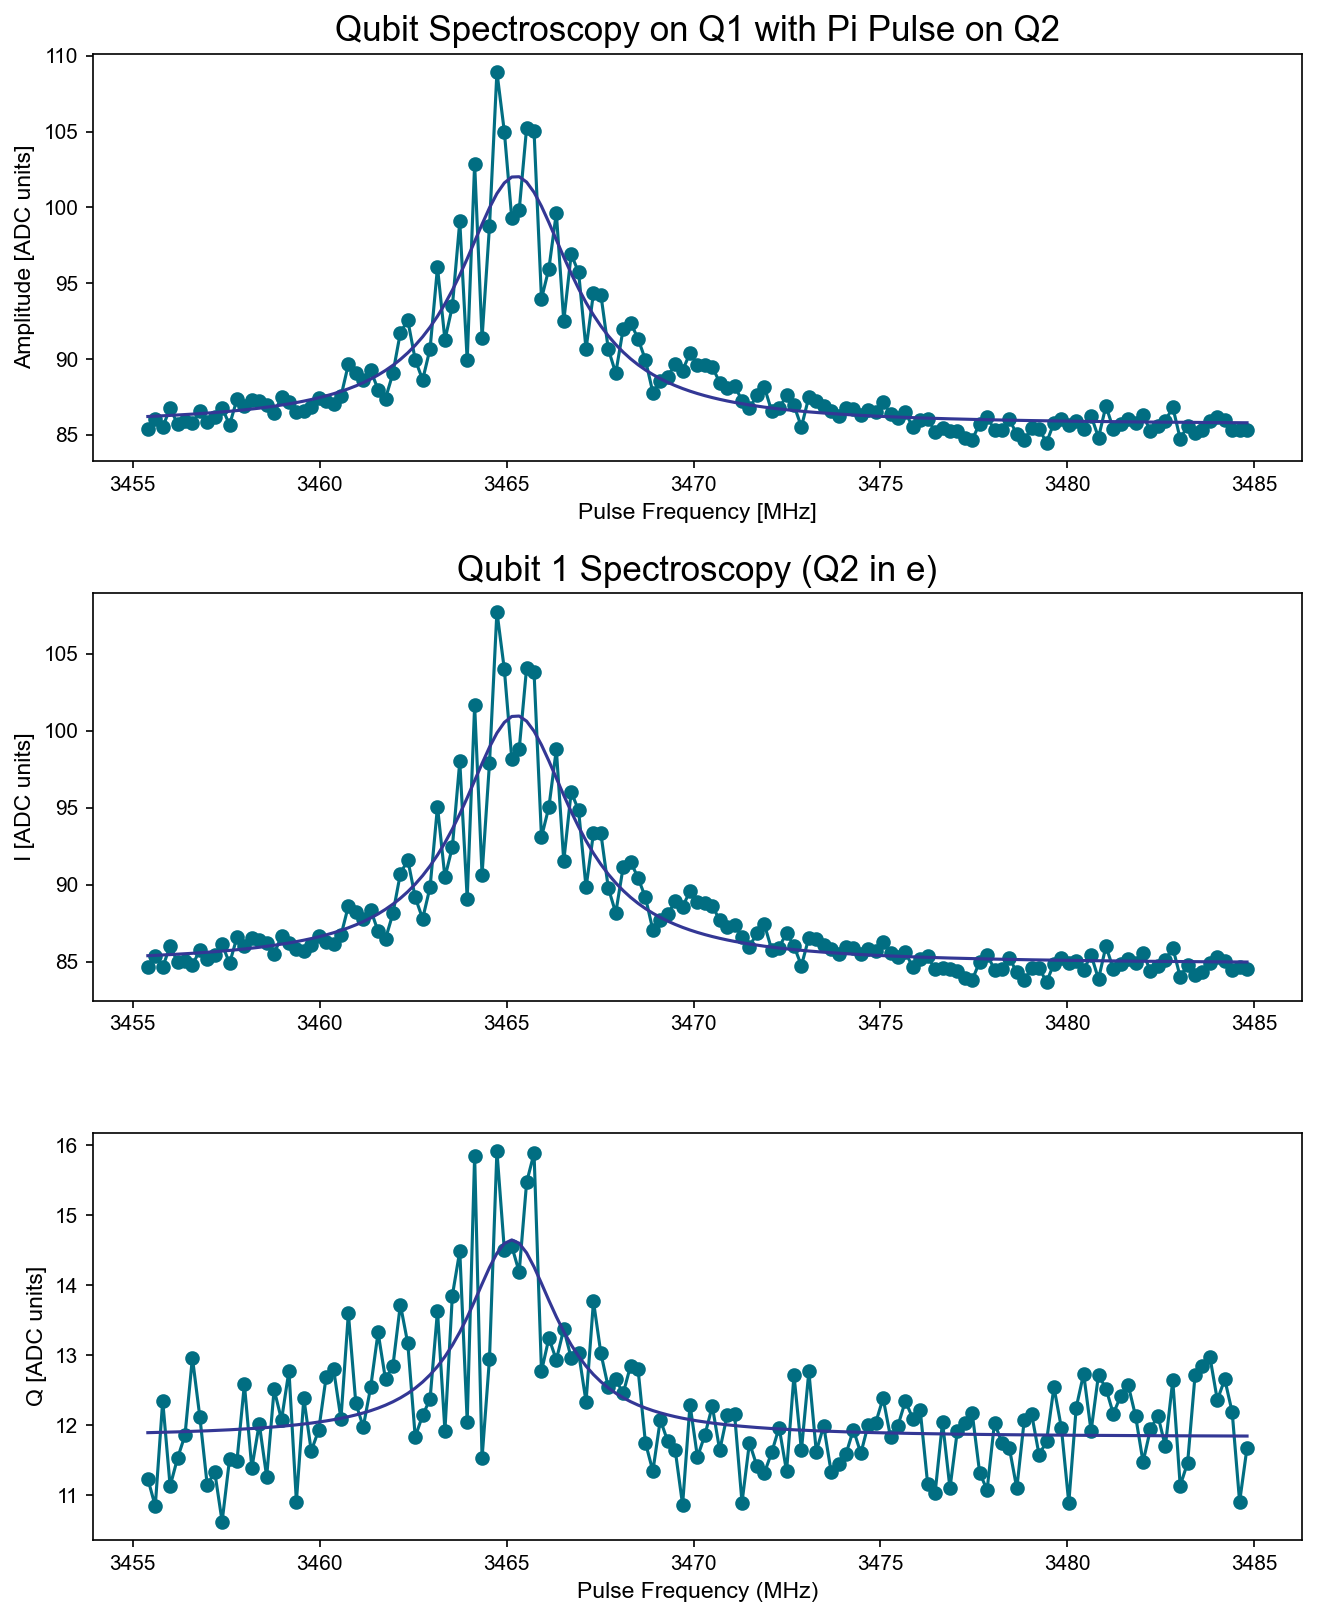

Fit Q1 frequency with ZZ shift [MHz]: 3465.252704343758
Q1 shift due to Q2 in e [MHz]: -4.9520598455269464


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3469.1160274474414, HWHM 1.421914763456133
Found peak in I at [MHz] 3469.120830775022, HWHM 1.4338093653901804
Found peak in Q at [MHz] 3468.9847810080296, HWHM 0.9758909716488008


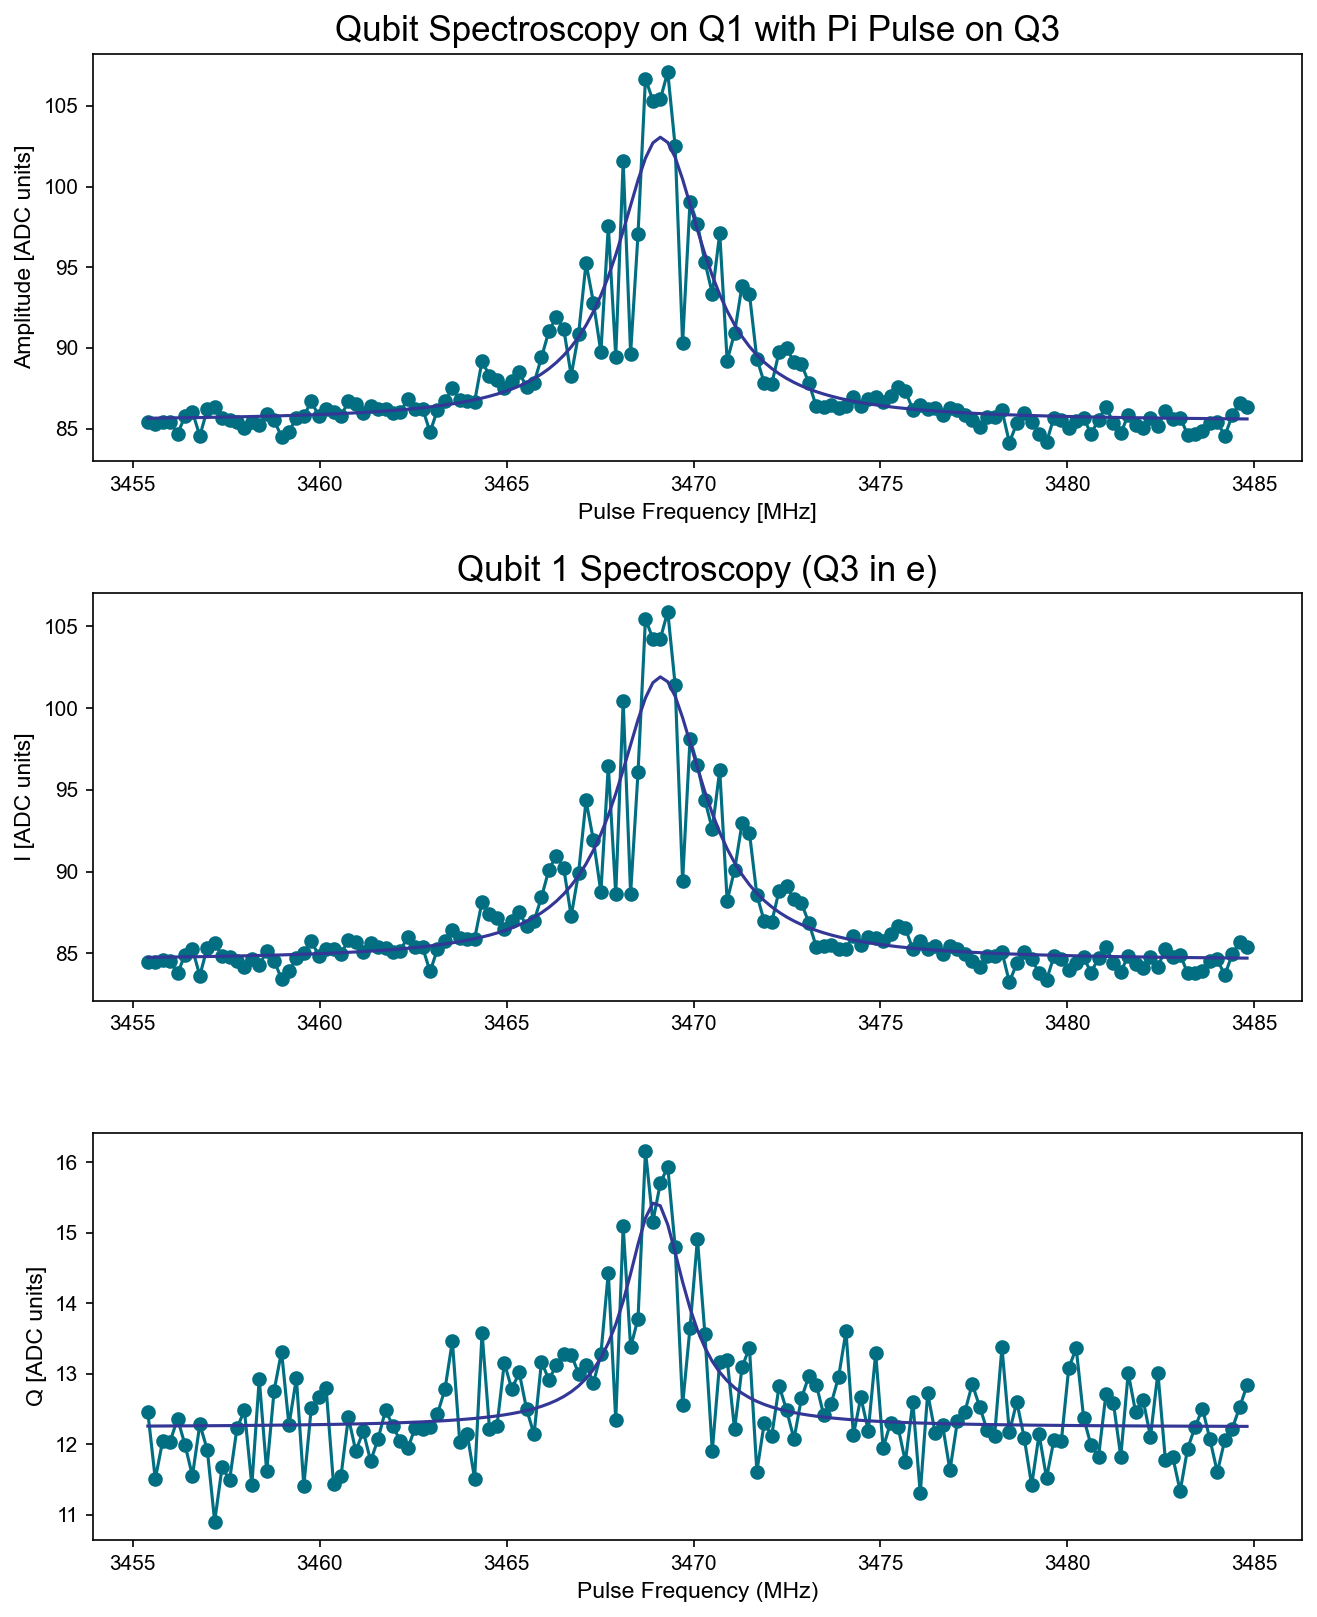

Fit Q1 frequency with ZZ shift [MHz]: 3469.120830775022
Q1 shift due to Q3 in e [MHz]: -1.0839334142629014


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 152.90001153485085, HWHM 1.484626447696675
Found peak in I at [MHz] 152.9199286603044, HWHM 1.4705109433894554
Found peak in Q at [MHz] 152.96417355847976, HWHM 1.4233528879757262


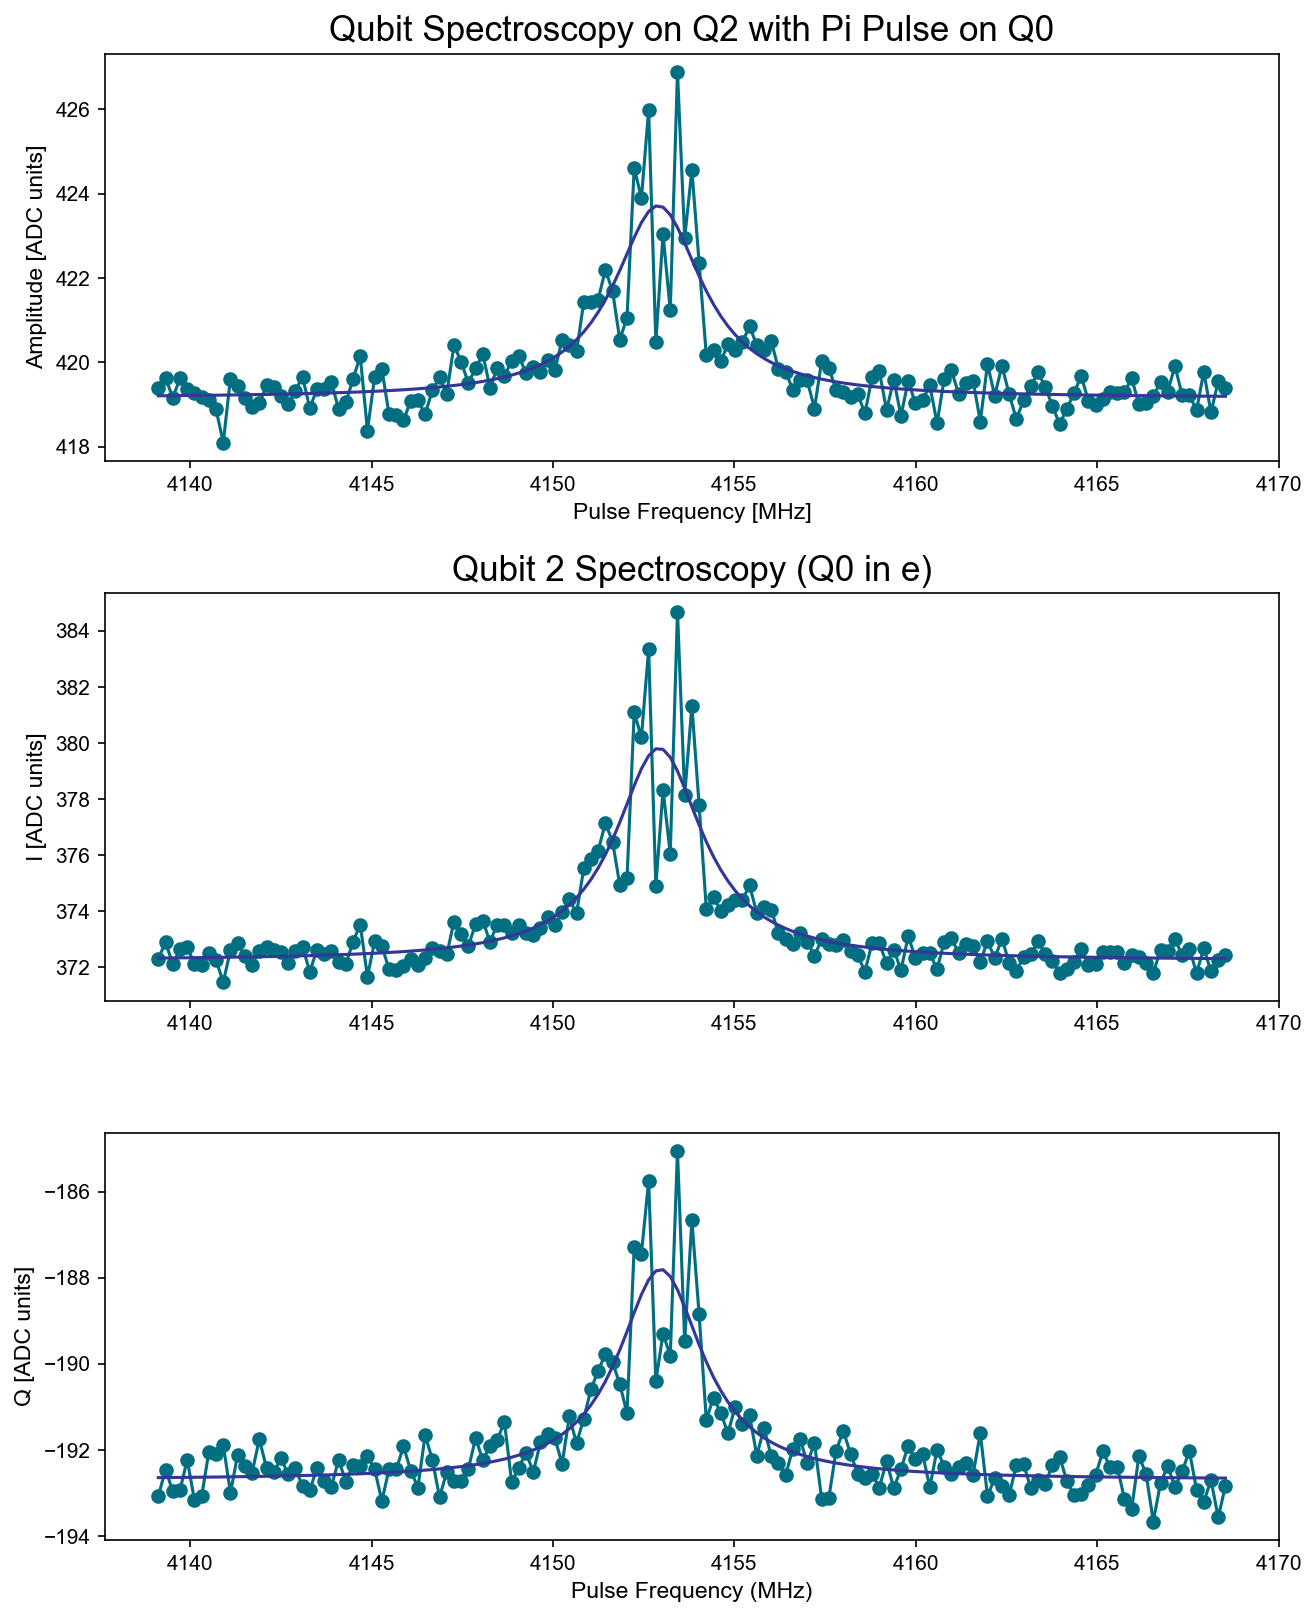

Fit Q2 frequency with ZZ shift [MHz]: 152.96417355847976
Q2 shift due to Q0 in e [MHz]: -0.96378881605159


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 148.49142476186546, HWHM 1.157634048806391
Found peak in I at [MHz] 148.48929020587704, HWHM 1.1488516872645798
Found peak in Q at [MHz] 148.49019378275116, HWHM 1.1082161773158268


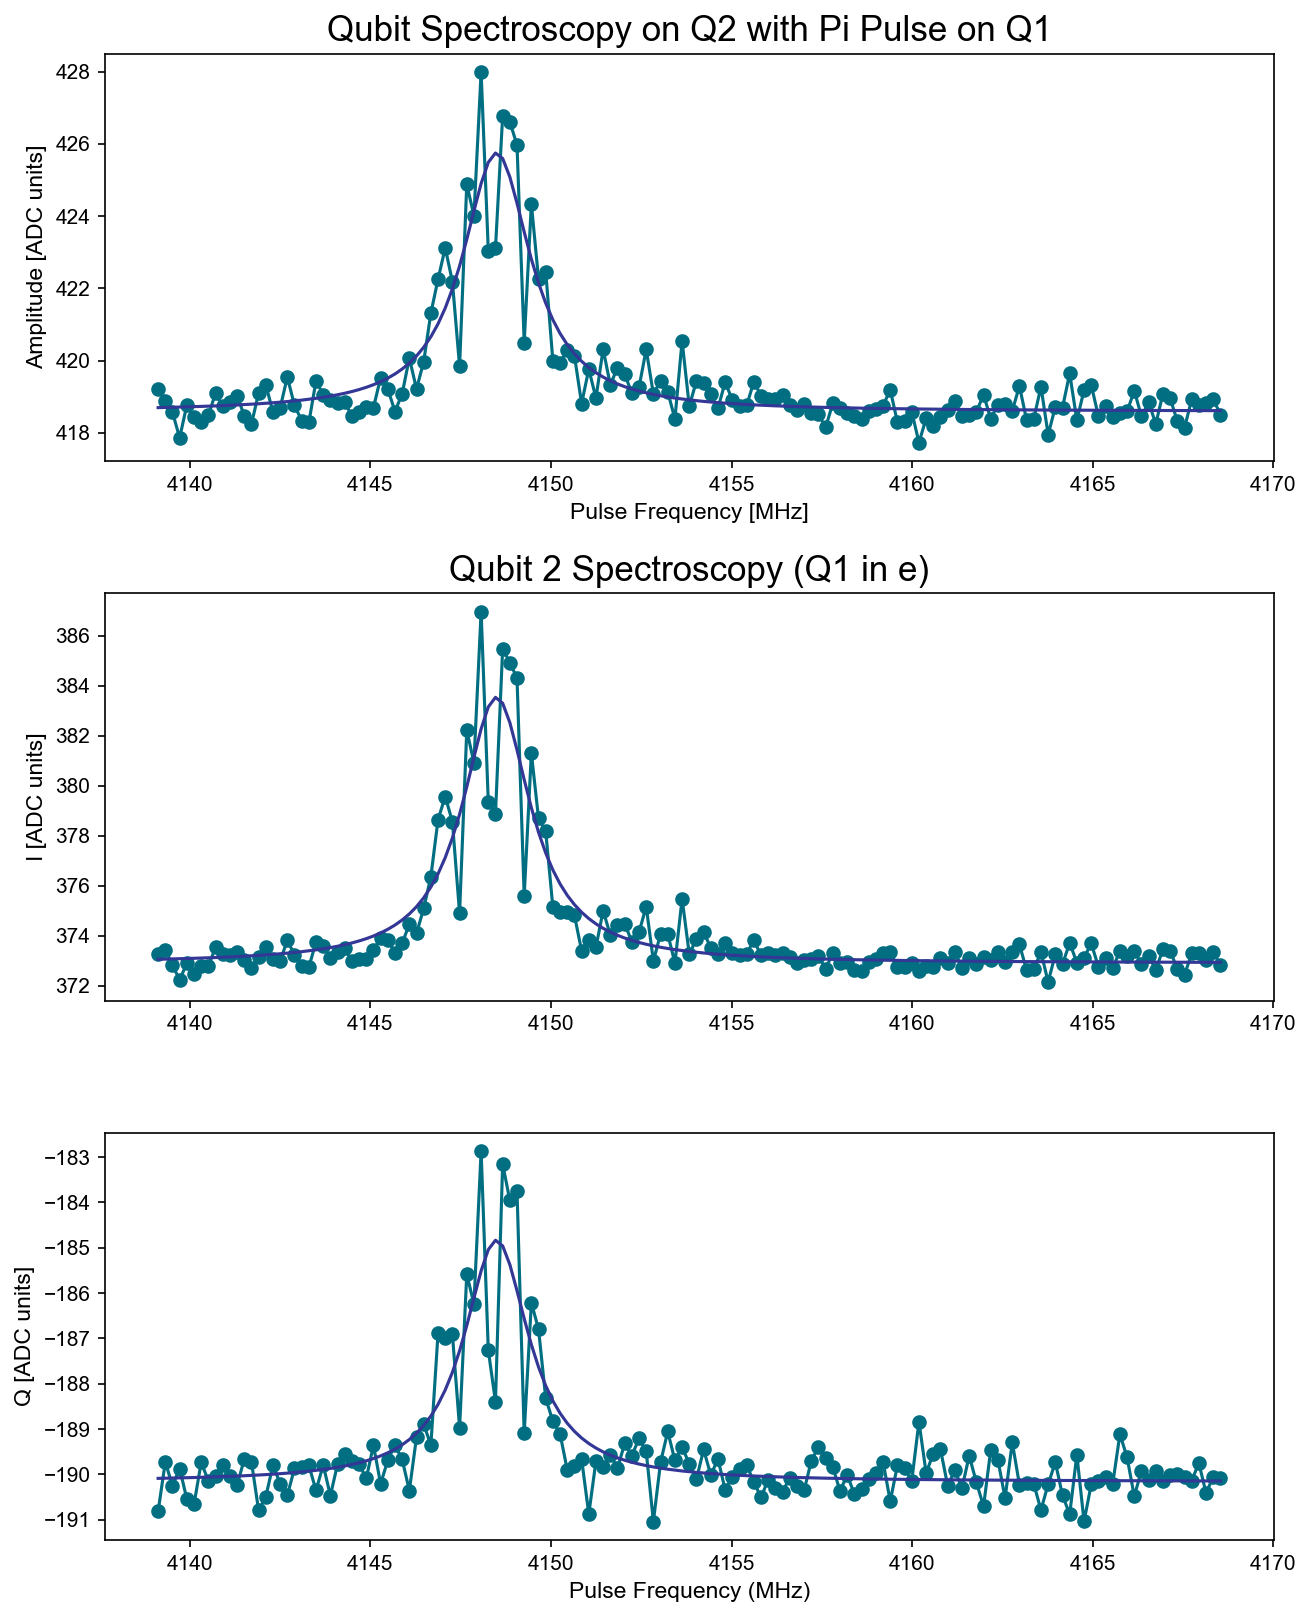

Fit Q2 frequency with ZZ shift [MHz]: 148.49142476186546
Q2 shift due to Q1 in e [MHz]: -5.436537612665887


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 152.74048560151235, HWHM 0.7544709799815051
Found peak in I at [MHz] 152.74626867816073, HWHM 0.7862559601787887
Found peak in Q at [MHz] 152.7574971354002, HWHM 0.8299033936869877


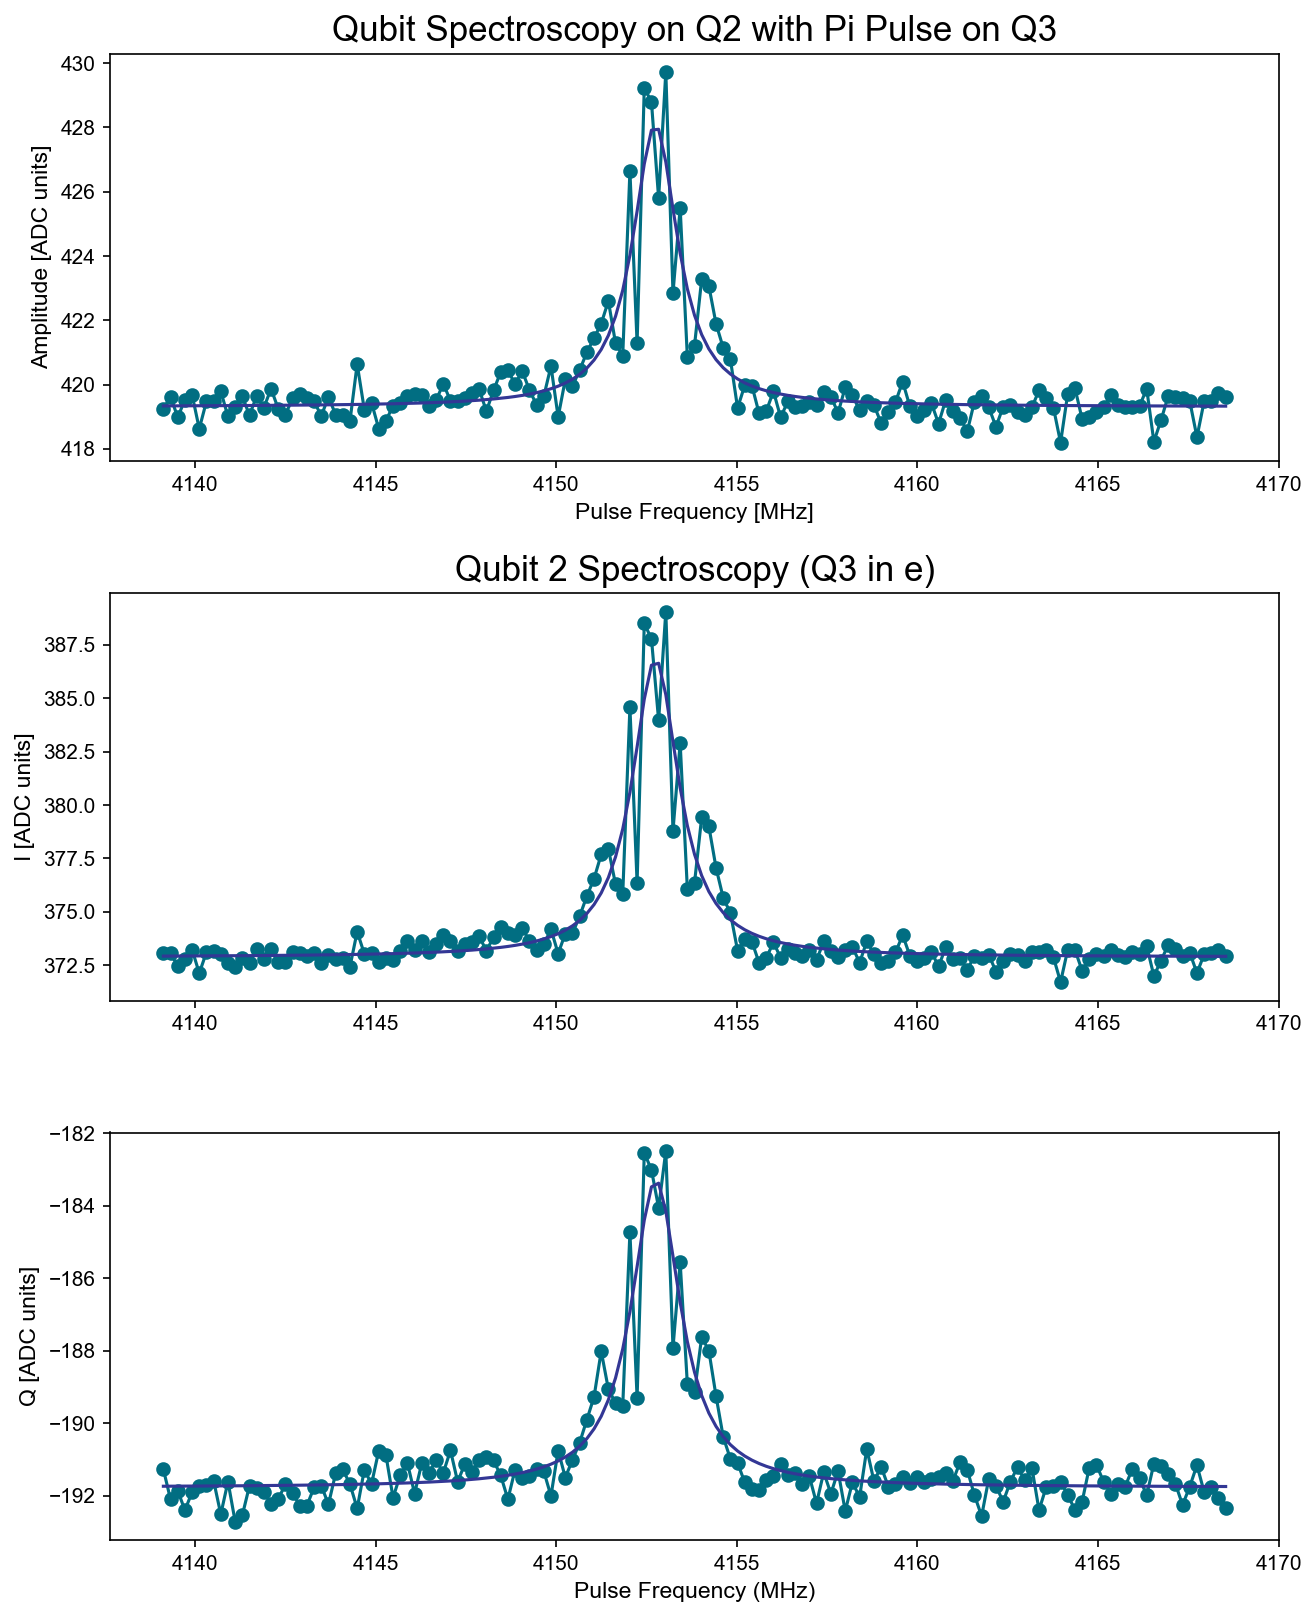

Fit Q2 frequency with ZZ shift [MHz]: 152.7574971354002
Q2 shift due to Q3 in e [MHz]: -1.170465239131147


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 446.46695260386554, HWHM 2.0345590110345757
Found peak in I at [MHz] 446.18035433327367, HWHM 2.140509002501197
Found peak in Q at [MHz] 446.36245116013134, HWHM 2.0720153291340875


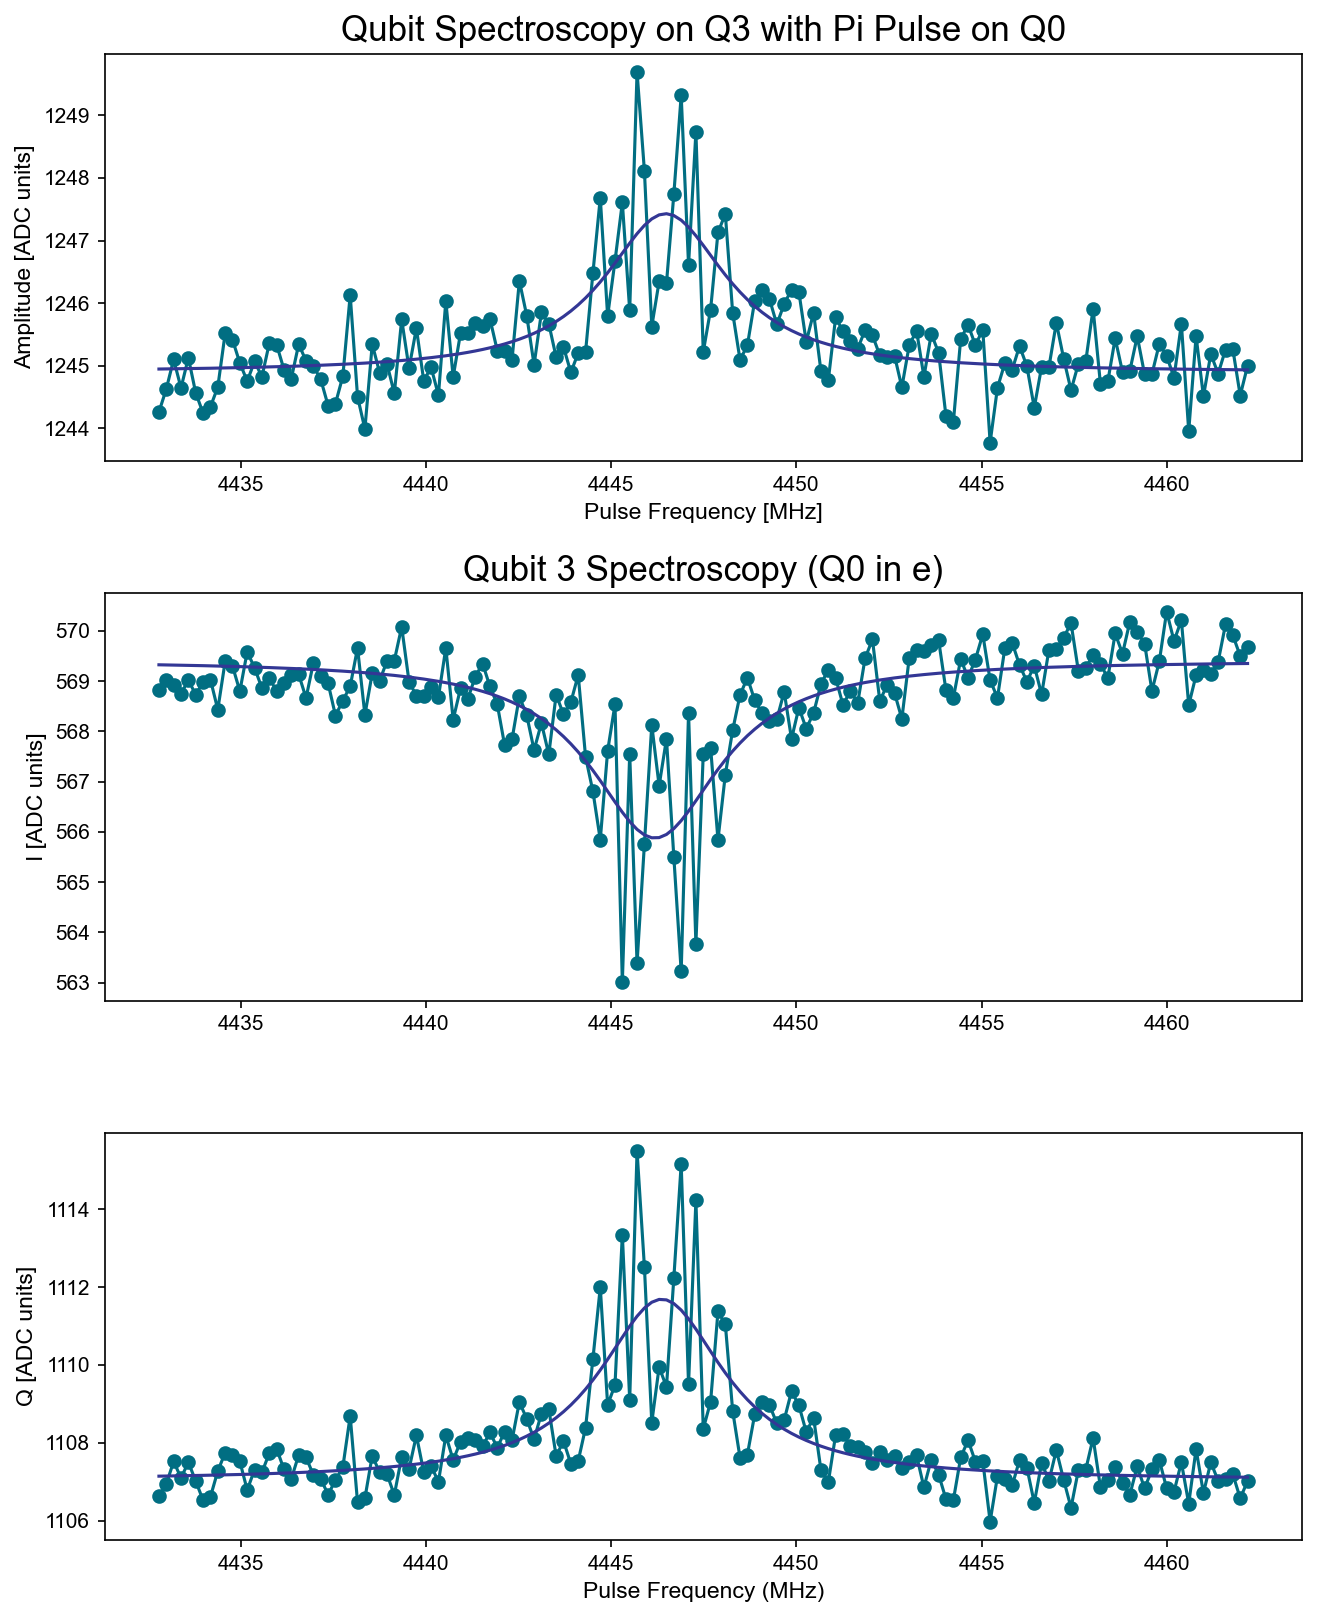

Fit Q3 frequency with ZZ shift [MHz]: 446.36245116013134
Q3 shift due to Q0 in e [MHz]: -1.21954126595557


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 445.7966063207576, HWHM 1.2844496657731124
Found peak in I at [MHz] 445.6117064567185, HWHM 1.7528897686696694
Found peak in Q at [MHz] 445.73630138539124, HWHM 1.433571961094128


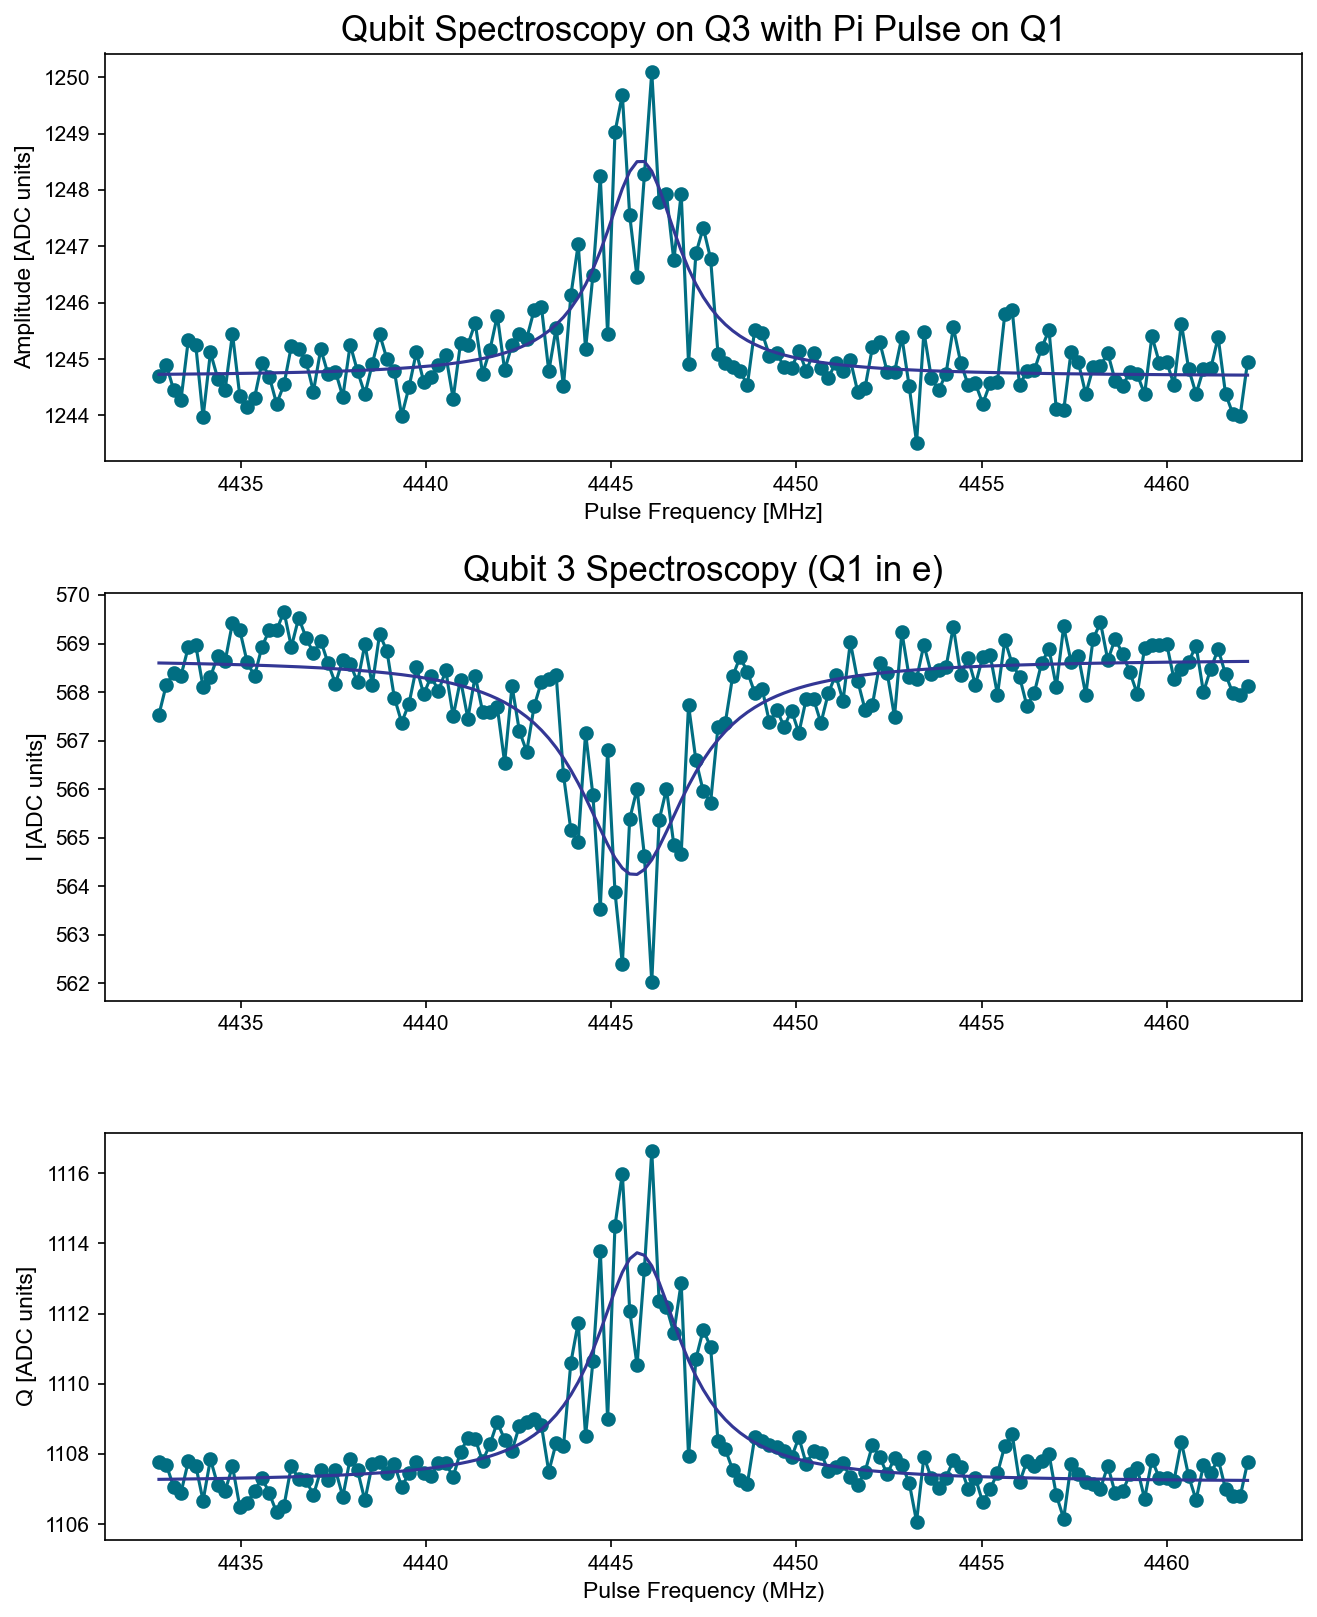

Fit Q3 frequency with ZZ shift [MHz]: 445.73630138539124
Q3 shift due to Q1 in e [MHz]: -1.8456910406956695


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 446.3378091824979, HWHM 1.2977828539703988
Found peak in I at [MHz] 446.40391258371295, HWHM 1.5776534154575588
Found peak in Q at [MHz] 446.3586808418978, HWHM 1.3892691799567518


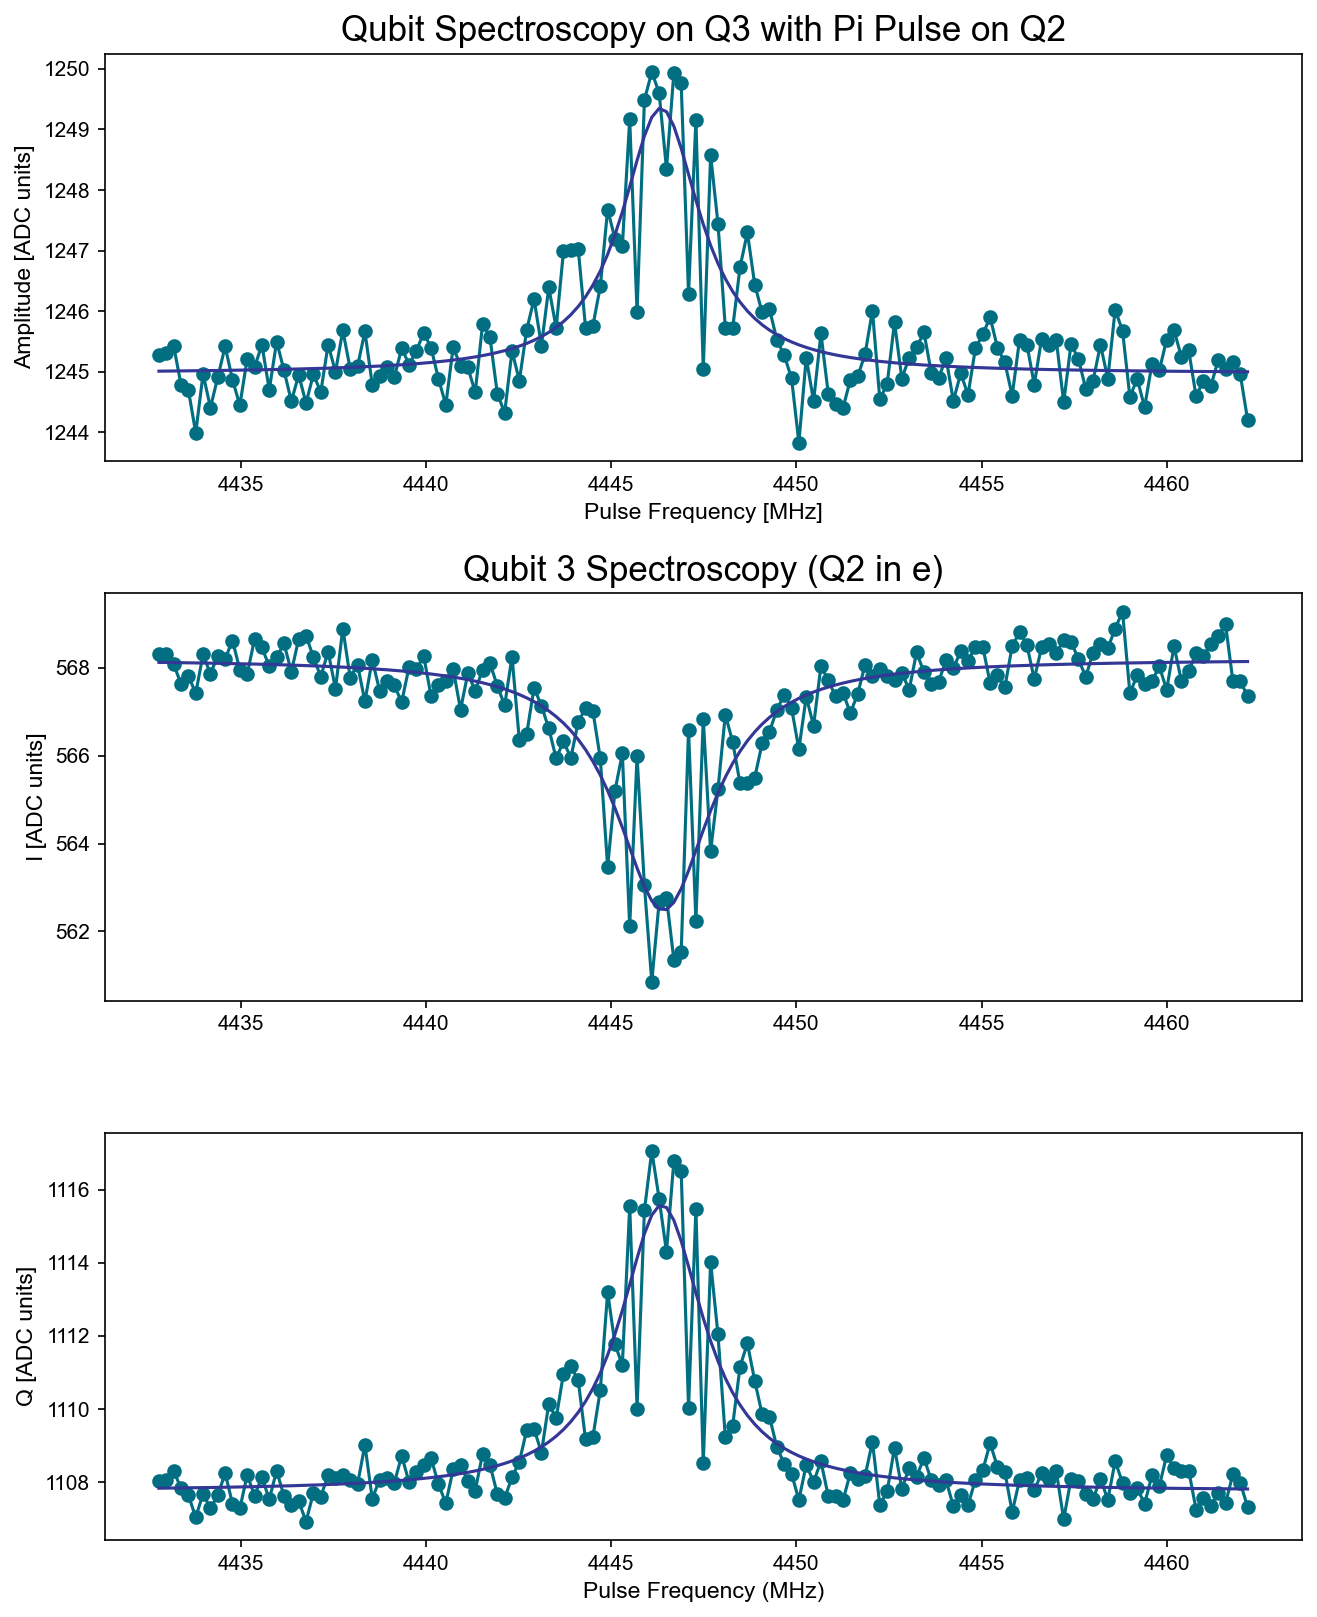

Fit Q3 frequency with ZZ shift [MHz]: 446.40391258371295
Q3 shift due to Q2 in e [MHz]: -1.1780798423739611
[[ 0.         -1.86025241 -0.99754732 -1.38184641]
 [-1.08702221  0.         -4.95205985 -1.08393341]
 [-0.96378882 -5.43653761  0.         -1.17046524]
 [-1.21954127 -1.84569104 -1.17807984  0.        ]]


In [50]:
for qubit0 in range(4):
    for qubit1 in range(4):
        if qubit1 == qubit0: continue
        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}{qubit1}",
            config_file=config_path,
        )
        
        span = 30
        npts = 151
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=300, # Number of averages per point
            rounds=10, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=5, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
            qubits=[qubit0, qubit1],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            assert False, 'All fits failed, please manually fix!'

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data, compare_param_i=1)
        ZZshifts[qubit0, qubit1] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qubit0]
        print(f'Fit Q{qubit0} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qubit0} shift due to Q{qubit1} in e [MHz]: {ZZshifts[qubit0, qubit1]}')
print(ZZshifts)

In [51]:
print(f'f_Q1_ZZ: {ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]}')

f_Q1_ZZ: [3469.11774198 3470.20476419 3465.25270434 3469.12083078]


# Get couplings by optimization

In [44]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [45]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [47]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)

In [52]:
x0 = np.array([100, 100, 100])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print(qubit_freqs_MHz)
print(alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds , method='L-BFGS-B')
print(f'Success: {result.success}')
print(f'Optimized g01, g12, g13 [MHz]: {1e3*result.x}')
gs_opt = result.x

[4826.62464193 3470.20476419 4153.92796237 4447.58199243]
[-189.34816859 -100.48046219 -225.82989132 -171.81765274]
Success: True
Optimized g01, g12, g13 [MHz]: [68.52475222 55.59802643 52.04236819]


In [53]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -1.86025241 -0.99754732 -1.38184641]
 [-1.08702221  0.         -4.95205985 -1.08393341]
 [-0.96378882 -5.43653761  0.         -1.17046524]
 [-1.21954127 -1.84569104 -1.17807984  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.         -1.56355121 -0.0429644  -0.08201372]
 [-1.56355121  0.         -5.24175159 -1.64004059]
 [-0.0429644  -5.24175159  0.         -0.19275699]
 [-0.08201372 -1.64004059 -0.19275699  0.        ]]
Optimization error: 7.457976363308813
